<a href="https://colab.research.google.com/github/sayandas96476/gemstone-identification-using-deep-learning-approach/blob/main/Inception%20V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
from sklearn.metrics import confusion_matrix


In [ ]:
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -u /content/drive/MyDrive/test.zip -d /content
!unzip -u /content/drive/MyDrive/train.zip -d /content

Archive:  /content/drive/MyDrive/test.zip
Archive:  /content/drive/MyDrive/train.zip


In [ ]:
train_path = '/content/train'
test_path = '/content/test'
BATCH_SIZE = 64
IMG_SIZE = 
seed=123
input_shape = (IMG_SIZE,IMG_SIZE)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
  
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,\
                                   rotation_range=15, shear_range=10,\
                                   zoom_range=0.1, fill_mode='nearest', \
                                   height_shift_range=0.05, width_shift_range=0.1)

valid_gen = valid_datagen.flow_from_directory(directory=train_path,subset='validation',
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    interpolation='nearest'
)

train_gen = train_datagen.flow_from_directory(subset='training',
    directory=train_path,
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    interpolation='nearest'
)

Found 543 images belonging to 87 classes.
Found 2313 images belonging to 87 classes.


In [ ]:
n_classes=87

In [ ]:
class_indices = train_gen.class_indices

In [ ]:
temp_df = pd.DataFrame({'class': train_gen.classes}).value_counts().reset_index().sort_values(by='class')
temp_df.columns = ['class', 'counts']

Number of images:  2313


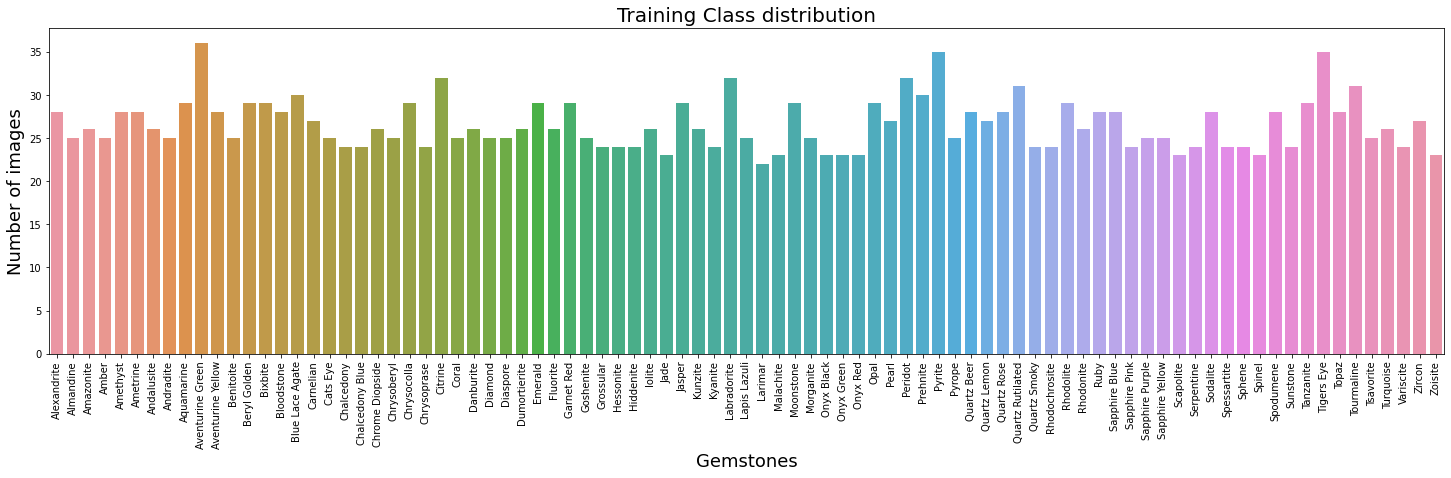

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(data=temp_df,
            x='class',
            y='counts')
plt.ylabel('Number of images', fontsize=18)
plt.xlabel('Gemstones', fontsize=18)
plt.title('Training Class distribution', fontsize=20)
plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

print('Number of images: ', np.sum(temp_df['counts'].values))

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception.layers:
  layer.trainable = False


In [ ]:
x = Flatten()(inception.output)
prediction = Dense(87, activation='softmax')(x)

In [ ]:
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from keras.metrics import TopKCategoricalAccuracy
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")]
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping

In [ ]:

checkpoint_path = "/content/drive/MyDrive/inceptionv3/weights.ckpt"


cp_callback = ModelCheckpoint(filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=0,
    mode='min')

history_cb = CSVLogger('/content/drive/MyDrive/inceptionv3/log.csv', separator=",", append=False)

In [ ]:
r = model.fit(
  train_gen,
  validation_data=valid_gen,
  epochs=30,
  callbacks=[history_cb,earlystopping_cb,cp_callback]
)

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 4.0070 - accuracy: 0.6956 - top-3 accuracy: 0.8353 - top-5 accuracy: 0.8915
Epoch 1: val_accuracy improved from -inf to 0.32044, saving model to /content/drive/MyDrive/inceptionv3/weights.ckpt
37/37 [==============================] - 35s 848ms/step - loss: 4.0070 - accuracy: 0.6956 - top-3 accuracy: 0.8353 - top-5 accuracy: 0.8915 - val_loss: 17.2084 - val_accuracy: 0.3204 - val_top-3 accuracy: 0.5009 - val_top-5 accuracy: 0.5764
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 2.3379 - accuracy: 0.7946 - top-3 accuracy: 0.9226 - top-5 accuracy: 0.9516
Epoch 2: val_accuracy improved from 0.32044 to 0.33517, saving model to /content/drive/MyDrive/inceptionv3/weights.ckpt
37/37 [==============================] - 30s 818ms/step - loss: 2.3379 - accuracy: 0.7946 - top-3 accuracy: 0.9226 - top-5 accuracy: 0.9516 - val_loss: 16.0053 - val_accuracy: 0.3352 - val_top-3 accuracy: 0.5175 - val_top-5 accuracy: 

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size = (224, 224),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 363 images belonging to 87 classes.


In [ ]:
model.load_weights(checkpoint_path)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")]
)


loss, acc, top3_acc, top5_acc = model.evaluate(test_set)
print("Restored model from checkpoint, accuracy: {:5.2f}%".format(100 * acc))
print("top 3_accuracy= , top 5_accuracy=",top3_acc, top5_acc)

6/6 [==============================] - 3s 189ms/step - loss: 15.8861 - accuracy: 0.4408 - top-3 accuracy: 0.5923 - top-5 accuracy: 0.6722
Restored model from checkpoint, accuracy: 44.08%
top 3_accuracy= , top 5_accuracy= 0.5922865271568298 0.6721763014793396


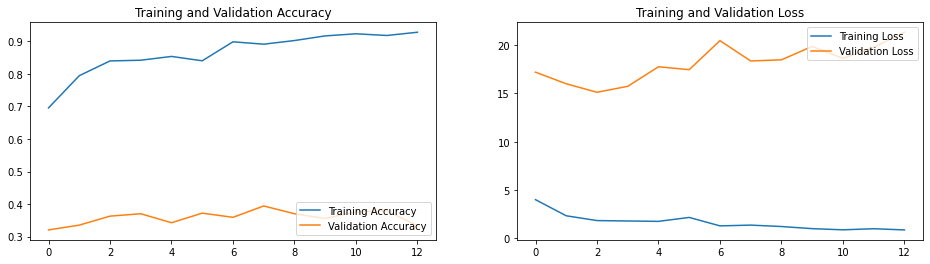

In [ ]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss'] 
val_loss = r.history['val_loss'] 
plt.figure(figsize=(16, 4)) 
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy') 
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 
plt.subplot(1, 2, 2) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show()

In [ ]:
def plot_confusion_matrix(data_gen, title=''):
    n_batches = int(np.ceil(data_gen.n/BATCH_SIZE))
    classes_df = pd.DataFrame()

    for batch in np.arange(n_batches):
        classes = np.argmax(data_gen[batch][1], axis=1)
        temp_df = pd.DataFrame(classes)
        classes_df = classes_df.append(temp_df, ignore_index=True)
    classes_df.columns = ['true_class']

   
    logits = model.predict(data_gen)
    probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

    classes_df['predicted_class'] = np.argmax(probs, axis=1)
    
    conf_matrix = confusion_matrix(classes_df.true_class.values, 
                                    classes_df.predicted_class.values, 
                                    labels=np.arange(n_classes))
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)
    
    plt.figure(figsize=(40,30))
    sns.heatmap(conf_matrix_norm, 
                cmap='viridis',
                annot=conf_matrix_norm,
                vmin=0, vmax=1,)
    _ = plt.title(title, fontsize=25)
    _ = plt.yticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=0)
    _ = plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

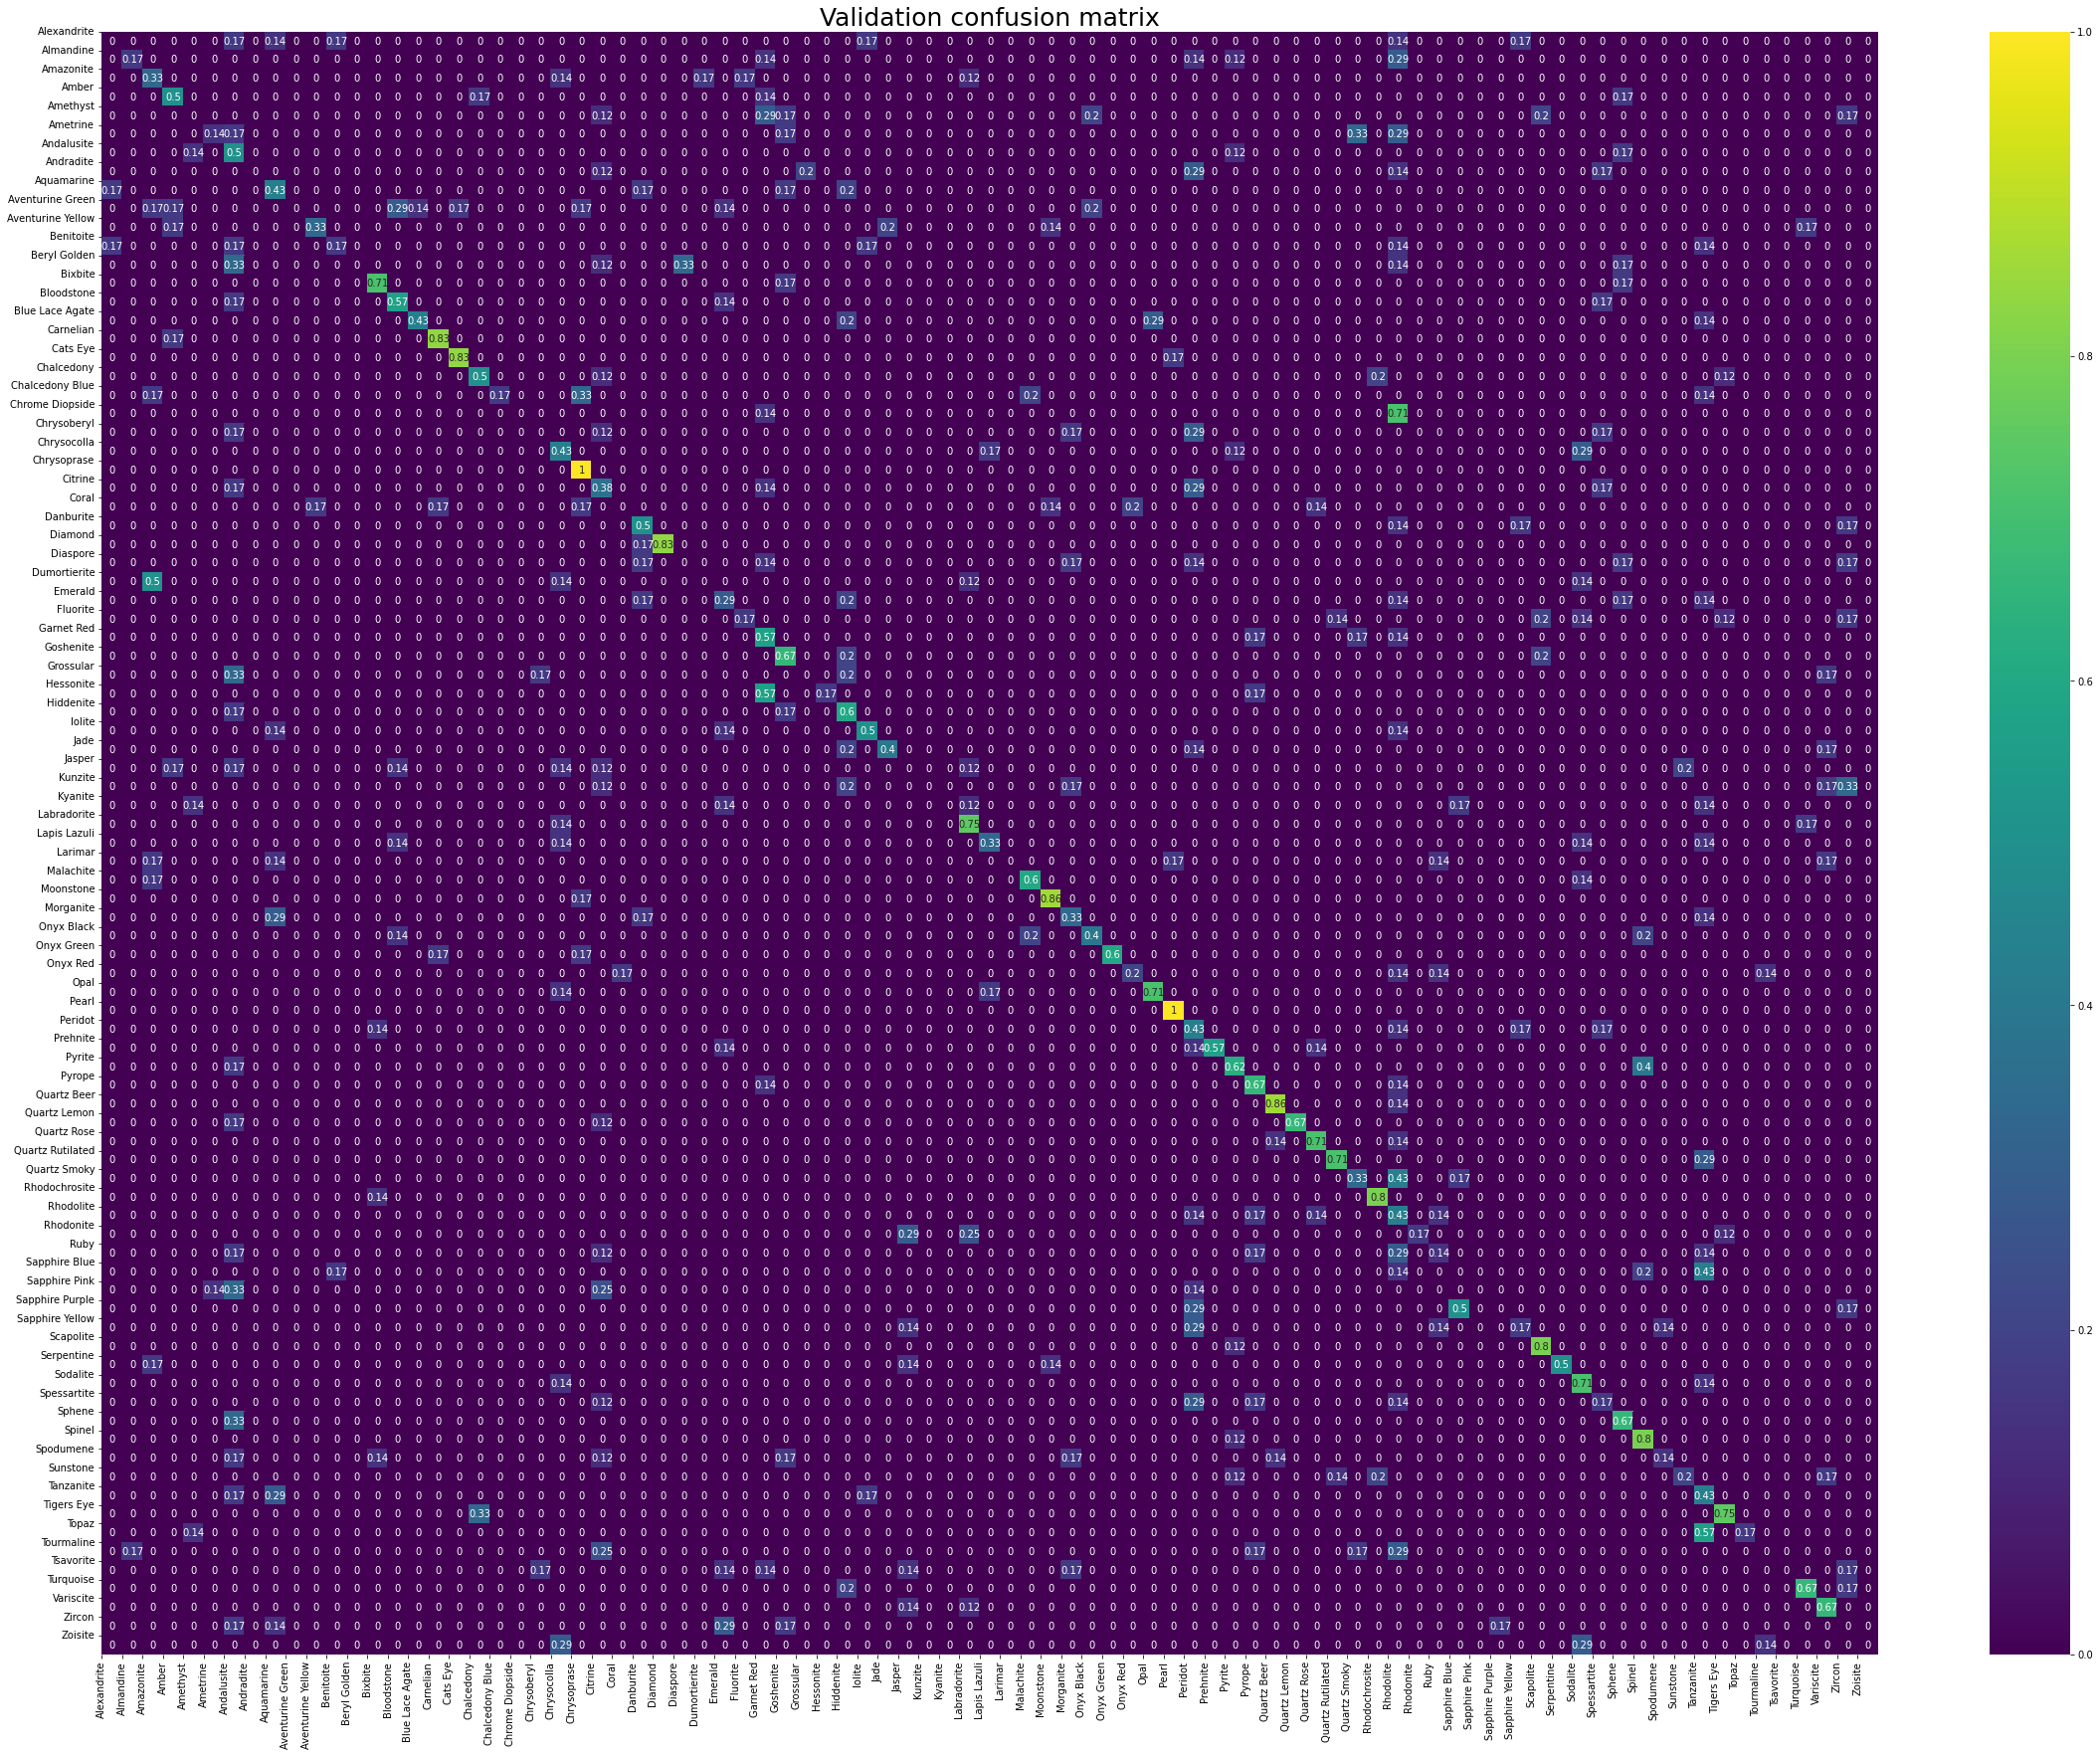

In [ ]:
plot_confusion_matrix(valid_gen, 'Validation confusion matrix')

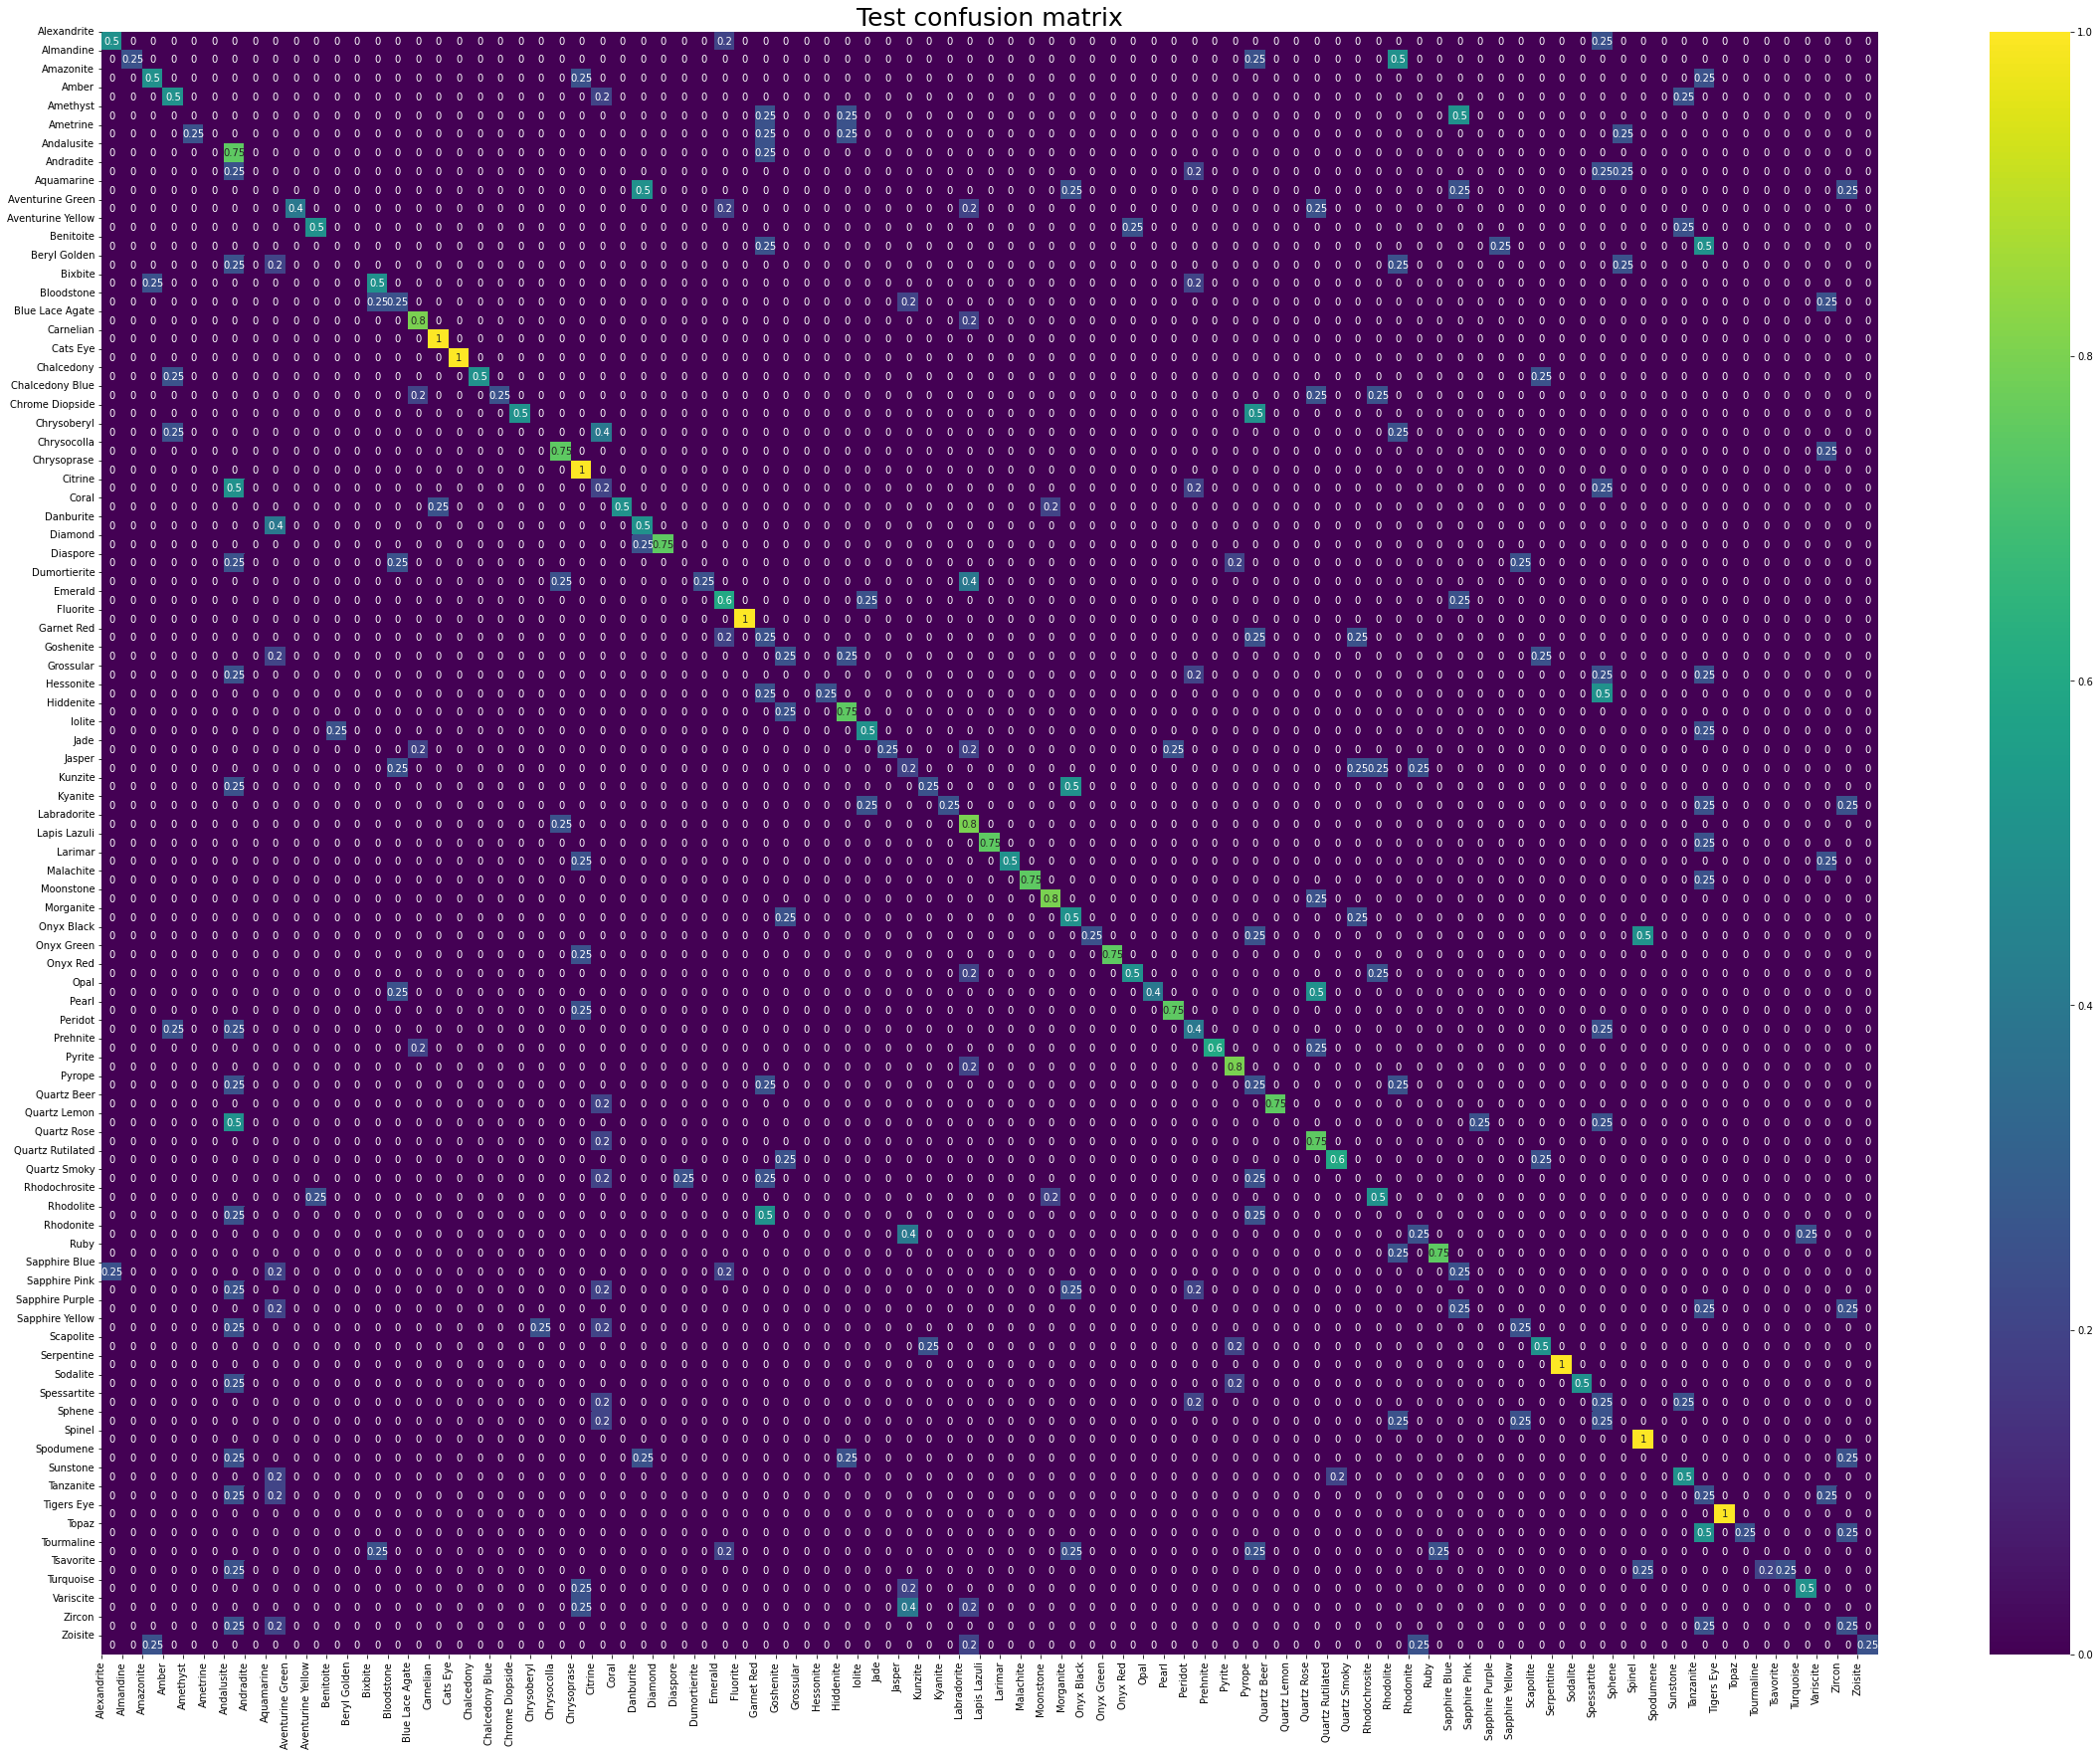

In [ ]:
plot_confusion_matrix(test_set, 'Test confusion matrix')

In [ ]:
n_batches = int(np.ceil(test_set.n/BATCH_SIZE))
classes_df = pd.DataFrame()

for batch in np.arange(n_batches):
    classes = np.argmax(test_set[batch][1], axis=1)
    temp_df = pd.DataFrame(classes)
    classes_df = classes_df.append(temp_df, ignore_index=True)
classes_df.columns = ['true_class']

In [ ]:
#logits and probs
logits = model.predict(test_set)
probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

classes_df['predicted_class'] = np.argmax(probs, axis=1)

In [ ]:
Y_true = classes_df["true_class"]
Y_pred = classes_df["predicted_class"]
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(Y_true,Y_pred,average='weighted')
recall = recall_score(Y_true,Y_pred,average='weighted')
f1 = f1_score(Y_true,Y_pred,average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("precision: ",precision,"\nrecall: ",recall,"\nf1_score: ",f1)

precision:  0.523955620845573 
recall:  0.44077134986225897 
f1_score:  0.43469457218931445
